# Сборный проект

У нас в доступе данные о играх выпускаемых с 1980 по 2016 год, с количеством их продажи на каких платформах они продаются и в каких регионах.Нужно выяснить факторы влиющие на успешность игры.

Name — название игры
Platform — платформа
Year_of_Release — год выпуска
Genre — жанр игры
NA_sales — продажи в Северной Америке (миллионы проданных копий)
EU_sales — продажи в Европе (миллионы проданных копий)
JP_sales — продажи в Японии (миллионы проданных копий)
Other_sales — продажи в других странах (миллионы проданных копий)
Critic_Score — оценка критиков (максимум 100)
User_Score — оценка пользователей (максимум 10)
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.



### Открытие файла и изучение общей информации 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats as st

pd.set_option('display.max_columns', None)

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Вывод
Сразу заметно что есть большое количество пропусков в данных, так же нужно заменить формат данных year_of_release с float64 на int64 так как год релиза не может быть не целым числом, user_score с object на float64 для дальнейщего  удобства работы с данными, но сначала надо будет порабоатать с пропусками. Для удобства работы нужно будет привести все названия столбцов к нижнему регистру.

### Подготовка дынных

In [5]:
games.columns = games.columns.str.lower()
#приводим названия столбцов к нижнему регистру

In [6]:
games.duplicated().sum()
#дубликаты не обнаружены

0

In [7]:
games.isna().sum()
#посмотрим пропущенные значения

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Так как данные с названием пропущены всего два значения удалим эти строки

In [8]:
games = games.dropna(subset = ['name'])

In [9]:
games.isna().sum()
#оказалось что пропущенные значения в названии совпали с пропусков и в столбце с жанром

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

In [10]:
games = games.dropna(subset = ['year_of_release'])

In [11]:
games['year_of_release'] = games['year_of_release'].astype('Int64')
#привели к нужному типу

In [12]:
games['critic_score'].unique()
#видим что тип данных лучше заменить не на float а на int

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [13]:
games['critic_score'] = games['critic_score'].astype('Int64')

In [14]:
#TBD это To Be Determined (будет определено) скорее всего либо не было отзывов вообше, либо их было очень мало для формирования рейтинга
#Заменим значение "tbd" - "to be determined" на NaN
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype('float')

In [15]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [16]:
games[games.duplicated(['name','year_of_release','platform'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83,5.5,E,0.01


найден один неявный дубликат

In [17]:
games = games.drop(labels=[16230],axis = 0)

In [18]:
games.reset_index(drop=True)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16438,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,NaN,0.01
16439,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,NaN,0.01
16440,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,NaN,0.01
16441,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,NaN,0.01


In [19]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38


In [20]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
total_sales           0
dtype: int64

#### Вывод
Проверили данные на дубликаты и их не было обнаружено, привели все названия столбцов к нижнему регистру для удобства.

Нашли два пропуска в названиях и удалили данные строки и так же удалились стоки и с пропускаи в жанре. Столбцы с годом релиза привели к типу данных int, так же столбец с оценкой от критиков в итоге привели к типу int из-за того что все оценки целые числа.TBD это не оценненые или еще ждут оценки заменили на значение пропуска NaN.

Остальные пропуски не трогали по причинам их большого количества, данные пропуски могли появиться из-за технической ошибки, или из-за отуствия этих данных.

Добавили столбец с сумарным количевством продаж сложив продажи во всех регионах.

### Исследовательский анализ данных

#### Данные о количестве выпускаемых игр по годам

array([[<AxesSubplot:title={'center':'year_of_release'}>]], dtype=object)

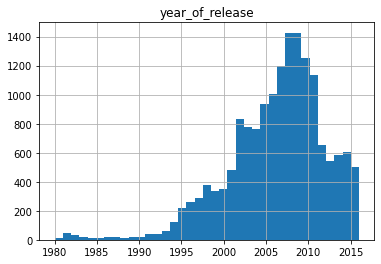

In [21]:
games.hist('year_of_release', bins = 37)

In [22]:
games['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     652
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: Int64

По графику виддно что кол-во выпускаемых игр до 1995 года очень малы, пик же выпуска игр пришел на 2006-2011 далее начался спад связанный с появлением новых технологий разроботок игр,что повлекло увелечение срока производства новых игр.

#### Данные о продажах по платформах

In [23]:
platforms_ascending = games.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False)
top10_platforms = platforms_ascending.reset_index()
iloc_top10_platforms = top10_platforms.iloc[0:10]
top10_platforms = iloc_top10_platforms['platform'].unique()
platforms_ascending

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


<AxesSubplot:xlabel='platform'>

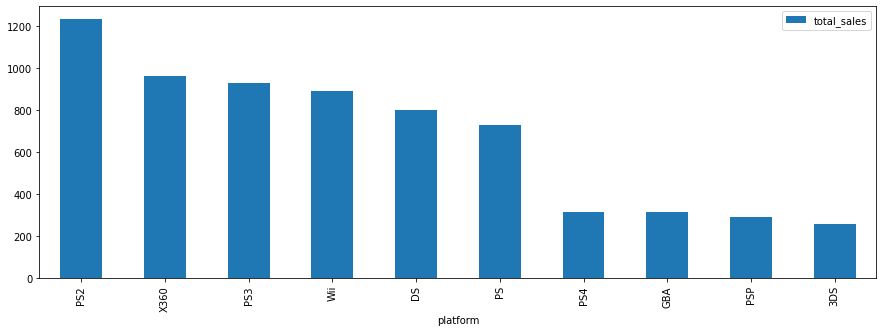

In [24]:
iloc_top10_platforms.plot(x="platform", y="total_sales", kind='bar', figsize=(15,5))

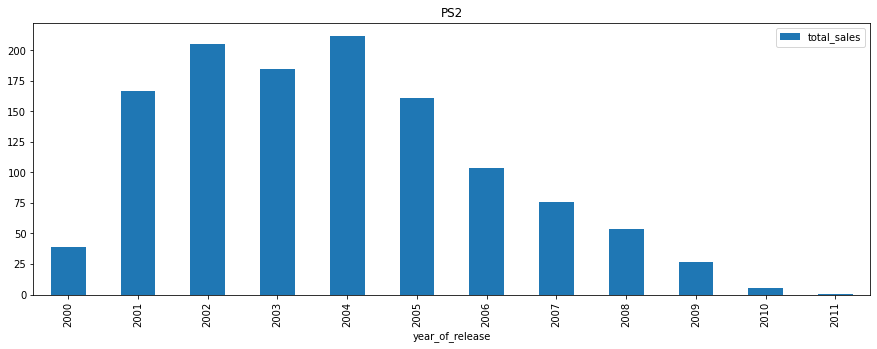

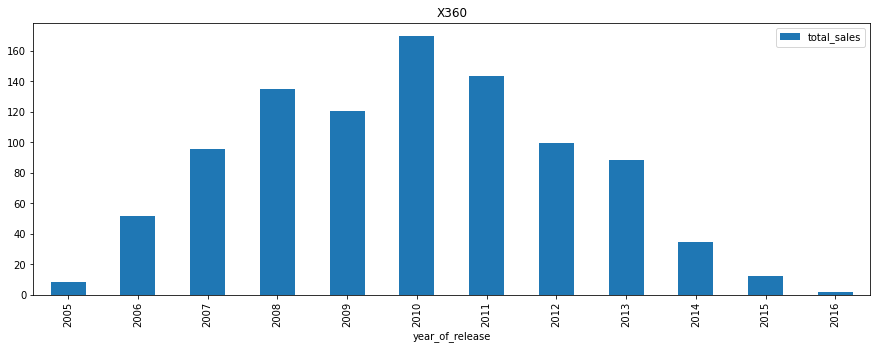

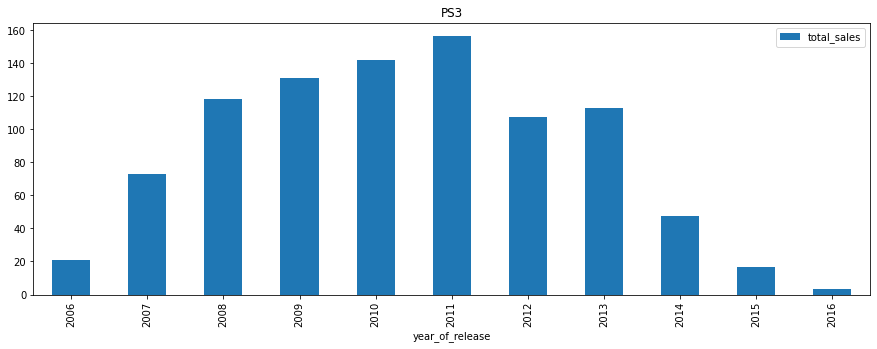

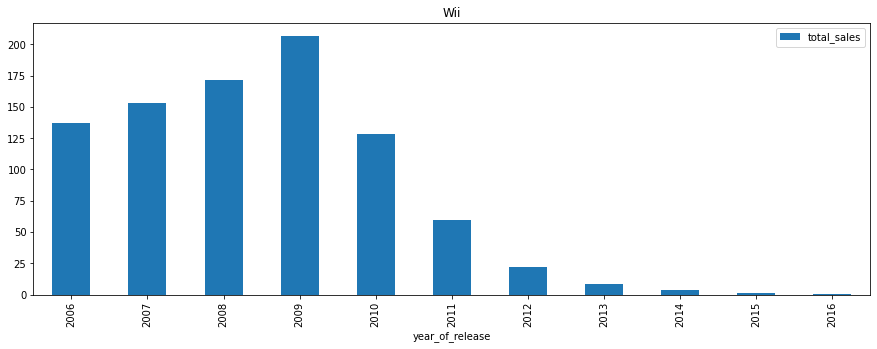

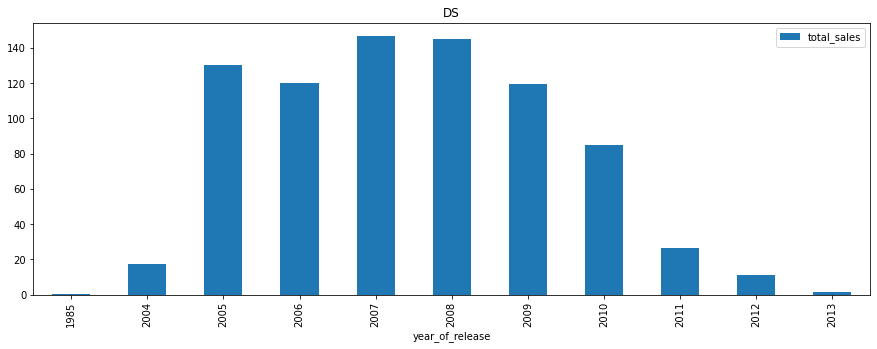

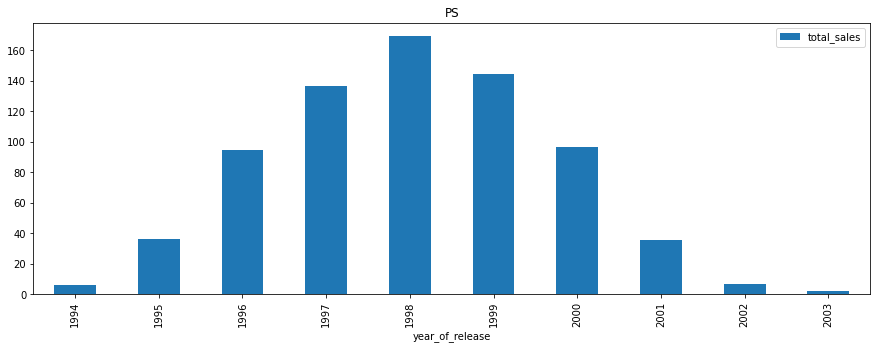

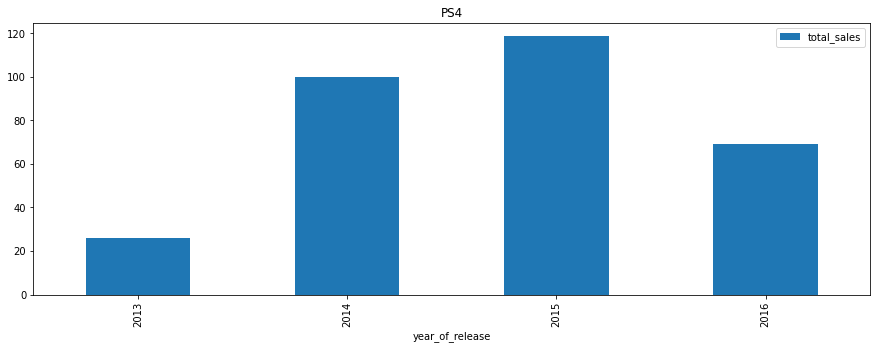

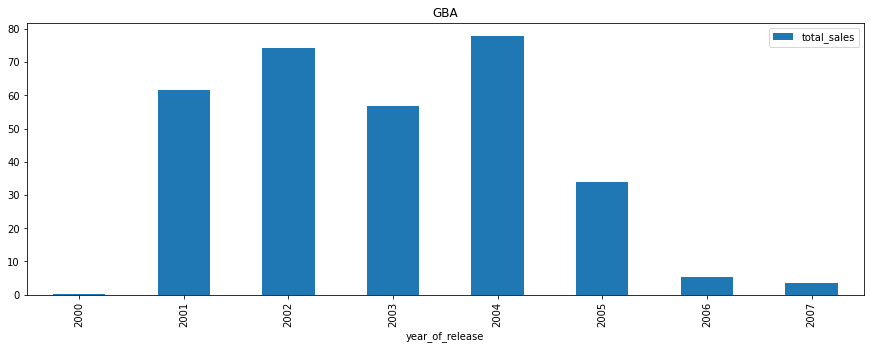

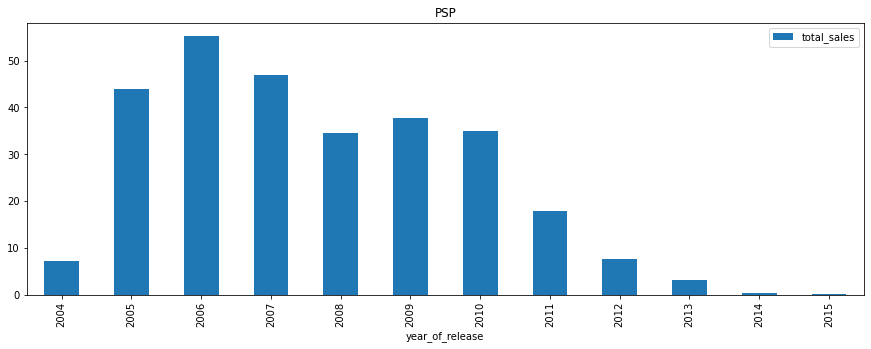

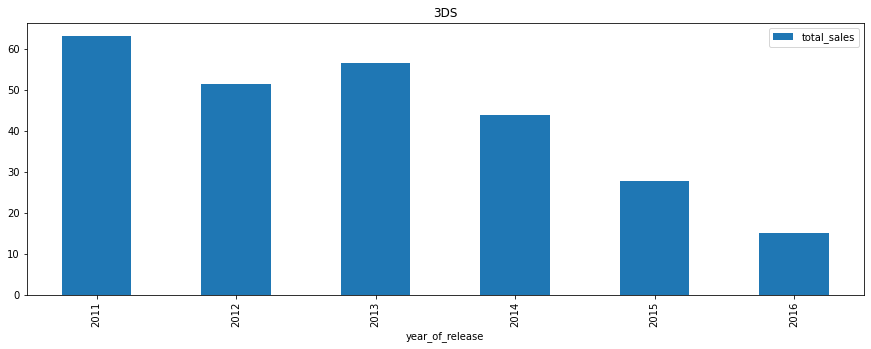

In [25]:
for platform in top10_platforms:
    games[games['platform'] == platform].pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum').plot(kind = 'bar', figsize=(15,5))
    plt.title(platform)

По данным видно что средний срок жизни платформы 10 лет, в таком случае для прогноза на 2017 и далее актуальнее брать для рассчетов данные с 2012 года.

#### Анализ

In [26]:
actual_data = games.query('year_of_release >= 2012')

<AxesSubplot:xlabel='year_of_release'>

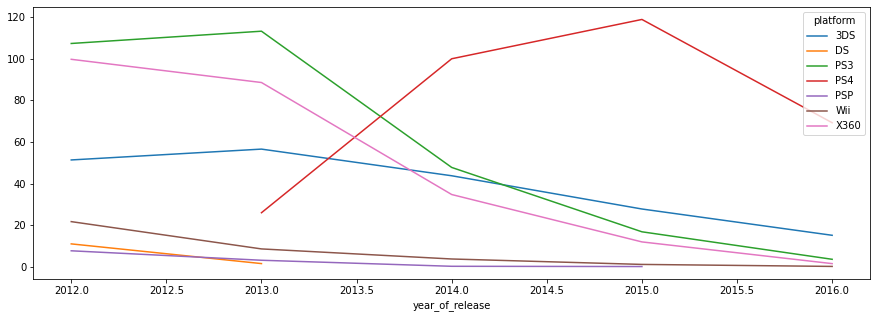

In [27]:
actual_data.query('platform in @top10_platforms').pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum').plot(figsize=(15, 5))

Все игры на платформах идут на снижение по продажам. Среди них игры на PS4 продаются гораздо чаще, скорее всего, потому что консоль появилась не так давно. PS4 является потенциально прибыльной, также PC, потому что показывает хоть небольшие, но стабильные продажи. падает сильнее всего спрос на консоли: X360, PS3. На остальные консоли уже давно упал спрос, либо вообще не продаются.

Итого потенциально прибыльные:

PC, PS4, XOne

Потенциально не будут продаваться:

X360, PS3

<AxesSubplot:>

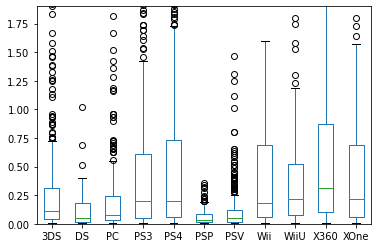

In [28]:
actual_data.pivot_table(index = 'name', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(kind='box', ylim=(0,1.9))

На графике мы видем, что мы не учли консоль только набирающую популярность - XOne. На нее было выпущено не так много игр, поэтому мы ее не включили в предыдущий график, но игры этой консоли очень хорошо продаются, потому что медианные значения PS4 и XOne почти совпадают. Добавим XOne в список потенциально прибыльных.

In [29]:
actual_data.pivot_table(index = 'name', columns = 'platform', values = 'total_sales', aggfunc = 'sum').describe()

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
count,396.000000,31.000000,250.00000,492.000000,392.000000,173.000000,411.000000,54.000000,147.000000,292.000000,247.000000
mean,0.491439,0.404839,0.25060,0.586951,0.801378,0.064682,0.119659,0.655000,0.559116,0.810068,0.645020
std,1.387161,1.439245,0.49464,1.464113,1.609456,0.071296,0.203011,1.165447,1.058836,1.712069,1.036139
min,0.010000,0.010000,0.01000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.040000,0.020000,0.03000,0.050000,0.060000,0.020000,0.020000,0.062500,0.080000,0.100000,0.060000
50%,0.110000,0.050000,0.08000,0.200000,0.200000,0.030000,0.050000,0.180000,0.220000,0.310000,0.220000
75%,0.312500,0.185000,0.24000,0.610000,0.730000,0.090000,0.120000,0.687500,0.525000,0.870000,0.685000
max,14.600000,8.060000,5.14000,21.050000,14.630000,0.360000,1.960000,6.760000,7.090000,16.270000,7.390000


На всех выбраных нами платформа PC PS4 И XONE имеются очень сильные выборсы максимальных продаж, это может быть связано с играми бесцеллерами. Медиана самая высокая у Xone потом идет ps4 и pc. На всех трех платформах так же сильны разброс по Q1 и Q3 это может быть связано с высокой продоваемастью игр на данных платформах.

#### Корреляция по платформам

In [30]:
PC = actual_data.query('platform == "PC"')

<AxesSubplot:xlabel='total_sales', ylabel='user_score'>

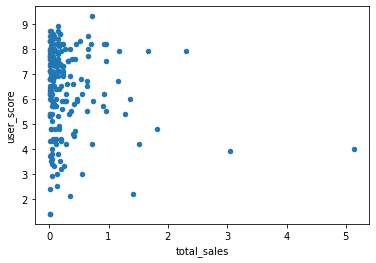

In [31]:
PC.plot(x='total_sales', y='user_score', kind='scatter')

<AxesSubplot:xlabel='total_sales', ylabel='critic_score'>

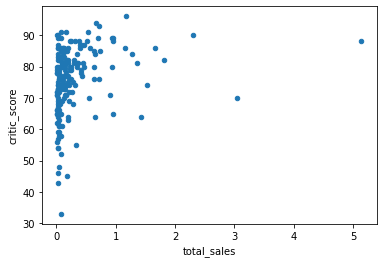

In [32]:
PC.plot(x='total_sales', y='critic_score', kind='scatter')

In [33]:
PC_cor = PC[['critic_score','user_score', 'total_sales']]
PC_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.432587,0.237243
user_score,0.432587,1.000000,-0.121867
total_sales,0.237243,-0.121867,1.000000


по этим данным можно сказать что оценк критиков влияют на количество продаж, а оценки от пользователей не так важны для покупки.

In [34]:
XOne = actual_data.query('platform == "XOne"')
PS4 = actual_data.query('platform == "PS4"')

In [35]:
PS4_cor = PS4[['critic_score','user_score', 'total_sales']]
PS4_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


<AxesSubplot:xlabel='total_sales', ylabel='critic_score'>

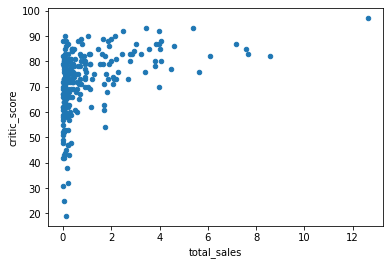

In [36]:
PS4.plot(x='total_sales', y='critic_score', kind='scatter')

<AxesSubplot:xlabel='total_sales', ylabel='user_score'>

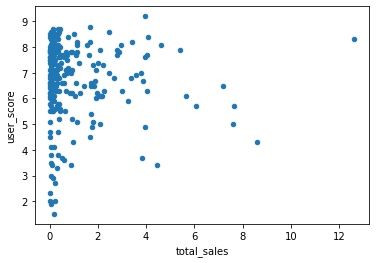

In [37]:
PS4.plot(x='total_sales', y='user_score', kind='scatter')

In [38]:
XOne_cor = XOne[['critic_score','user_score', 'total_sales']]
XOne_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000


<AxesSubplot:xlabel='total_sales', ylabel='critic_score'>

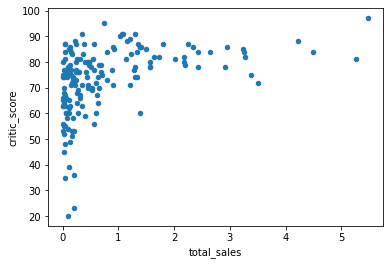

In [39]:
XOne.plot(x='total_sales', y='critic_score', kind='scatter')

<AxesSubplot:xlabel='total_sales', ylabel='user_score'>

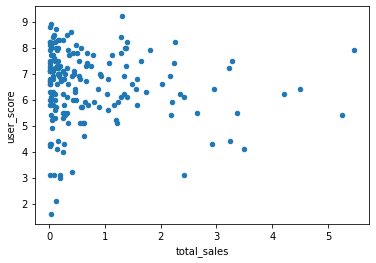

In [40]:
XOne.plot(x='total_sales', y='user_score', kind='scatter')

Данные по другим плтаформам так же подтвердили это утверждение, оценки критиков сильнее вляют на продажи

#### Общее распределение игр по жанрам

<AxesSubplot:xlabel='genre'>

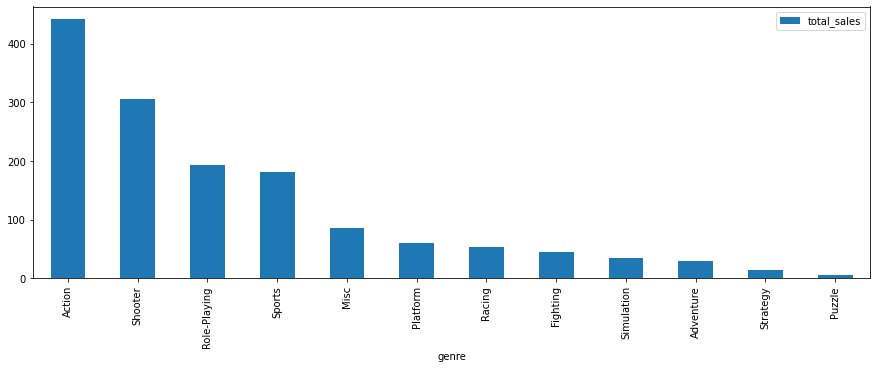

In [41]:
actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'total_sales').plot(kind='bar', figsize=(15,5), y= 'total_sales')

In [42]:
 actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'total_sales')

,total_sales
genre,
Action,441.12
Shooter,304.73
Role-Playing,192.80
Sports,181.06
Misc,85.04
Platform,61.00
Racing,53.50
Fighting,44.49
Simulation,35.12


Самые популярные жанры это экшн и шутеры, наимение популярные жанры пазлы и стратегии.

In [43]:
actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'mean').sort_values(ascending=False, by = 'total_sales')

,total_sales
genre,
Shooter,1.296723
Platform,0.717647
Sports,0.678127
Role-Playing,0.521081
Racing,0.465217
Misc,0.442917
Simulation,0.439000
Action,0.427856
Fighting,0.408165


<AxesSubplot:xlabel='genre'>

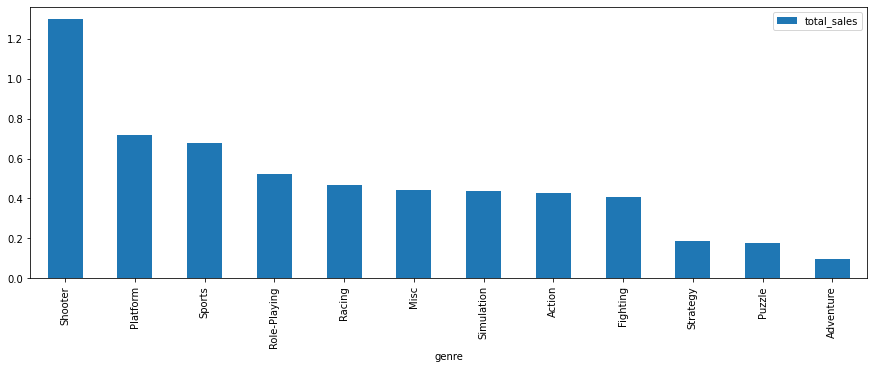

In [44]:
actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'mean').sort_values(ascending=False, by = 'total_sales').plot(kind='bar', figsize=(15,5), y= 'total_sales')

Среднее чило продаж больше всего у шутеров и игр платформеров, шутеры начиная с 2007 года стали очень популярными и их продажи сталбильно высокие. Платформеры же занимаю второе место по средним продажам вохможно из-за их малого количества но хороших продаж.

In [45]:
actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'median').sort_values(ascending=False, by = 'total_sales')

,total_sales
genre,
Shooter,0.440
Sports,0.240
Platform,0.210
Role-Playing,0.140
Racing,0.140
Fighting,0.130
Action,0.120
Misc,0.120
Simulation,0.120


<AxesSubplot:xlabel='genre'>

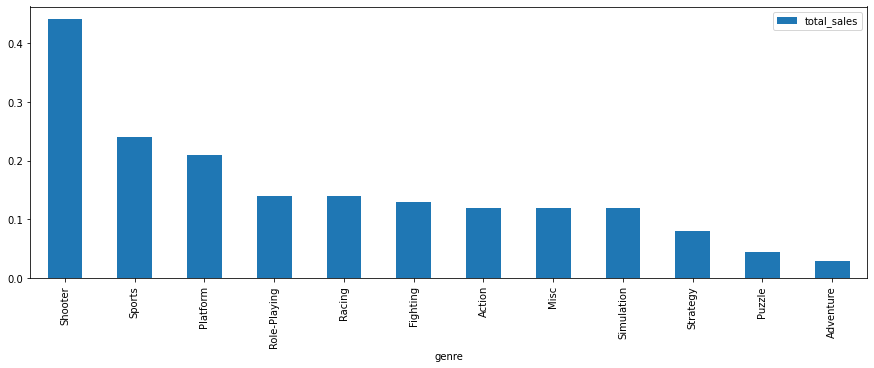

In [46]:
actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'median').sort_values(ascending=False, by = 'total_sales').plot(kind='bar', figsize=(15,5), y= 'total_sales')

В среднем значении продаж так же лидирует жанр шутера.


#### Вывод
Пик количества выпускаемых игр пришелся на 2006-2012 год что связано с актуальными платформами PS3 и Xbox360, с 2012 года количество уменьшилось из-за выхода новых игровых платформ и увелечения срока производства игр. Мы выявили средний срок иговой платформы 10 лет и для построения дальнейщих прогнозов взяли данные начиная с 2012 года.

Самыми популярными платформами являются PS2, Xbox360, PS3. Потонцеально прибыльными в будещем будет PS4, X One и PC из-за их актуальности а PS3 и Xbox360 потеряют свою популярность и прибыльность.

При количестве продаж на набирающих и популярных платформах видна корреляцию с оценкой критиков на продажи, самыми популярными жанрами являются экшены и шутеры.

### Портрет пользователя каждого региона

<AxesSubplot:xlabel='platform'>

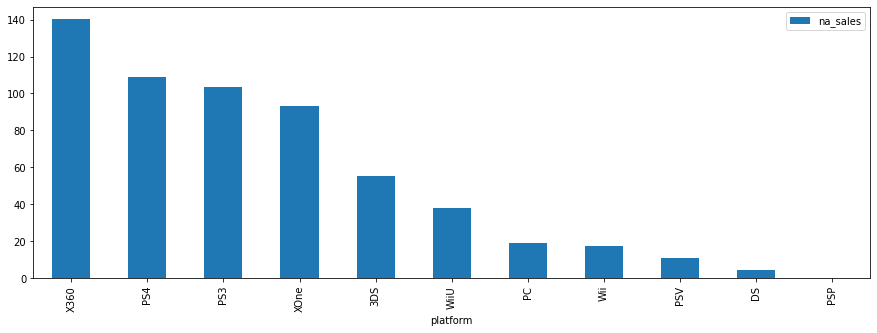

In [47]:
actual_data.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'na_sales').plot(kind = 'bar', figsize=(15,5))

Пользоватили северной америки предпочитают играть на платформа Xbox360, PS4 ,PS3, Xone и 3DS. Преобладают плтаформы нового и предыдущего поколения. Преобладающая доля на Xbox 360 возмодна связана с тем что иксбокс пренадлежит амереканской компании и более предпочительна среди пользователя и имеет более удачные маркетинговые компании на территории америки, но новое поколение PS уже быстро сокращает отставание.

In [48]:
actual_data.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'na_sales')

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19
Platform,25.38
Fighting,19.79
Racing,17.22
Adventure,8.92


<AxesSubplot:xlabel='genre'>

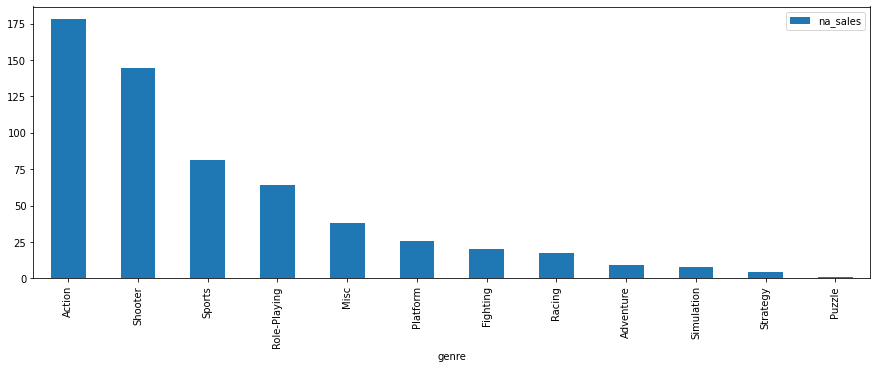

In [49]:
actual_data.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'na_sales').plot(kind = 'bar', figsize=(15,5))

В северной америке приобладают жанры экшн, шутер, спорт, ролевые игры и музыкальные.

<AxesSubplot:xlabel='platform'>

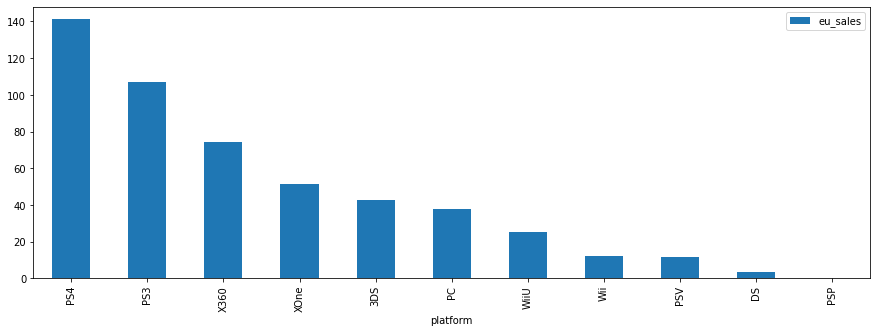

In [50]:
actual_data.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'eu_sales').plot(kind = 'bar', figsize=(15,5))

В европе преобладают платформы: PS4 , PS3, X360, XONE 3DS. Видно что новое и предыдущее покаление PS сильно преобладает на европейском рынке связано это может быть с маркетингом компании Sony.

In [51]:
actual_data.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'eu_sales')

,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.08
Role-Playing,48.53
Racing,27.29
Misc,26.32
Platform,21.41
Simulation,14.55
Fighting,10.79


<AxesSubplot:xlabel='genre'>

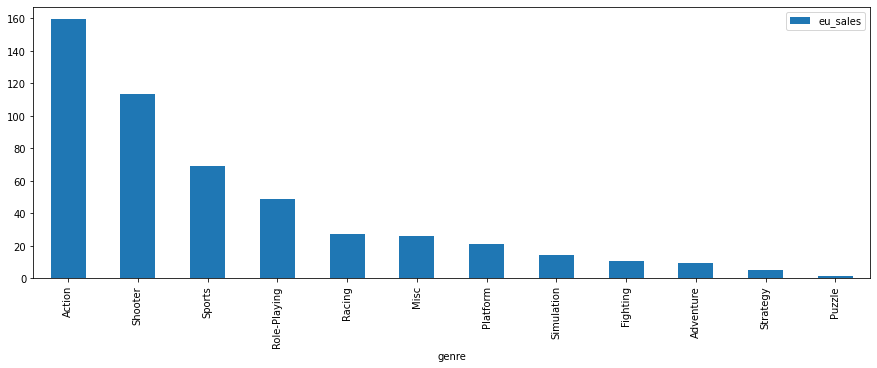

In [52]:
actual_data.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'eu_sales').plot(kind = 'bar', figsize=(15,5))

В европе преобладают жанры экшн, шутер, спорт, ролевые игры и гонки.

<AxesSubplot:xlabel='platform'>

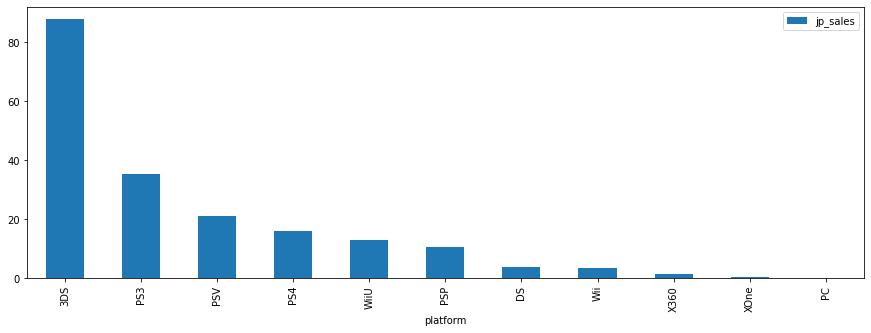

In [53]:
actual_data.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'jp_sales').plot(kind = 'bar', figsize=(15,5))

На японском рынке с большим отрывом преобладает платформа 3DS Ддалее идут PS3, PSV, PS4, WIIU. Преобладают исключительно японские компании, 3ds является явно очень популярной портативной плтаформой.

In [54]:
actual_data.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'jp_sales')

,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44
Shooter,9.23
Platform,8.63
Adventure,8.24
Sports,8.01


<AxesSubplot:xlabel='genre'>

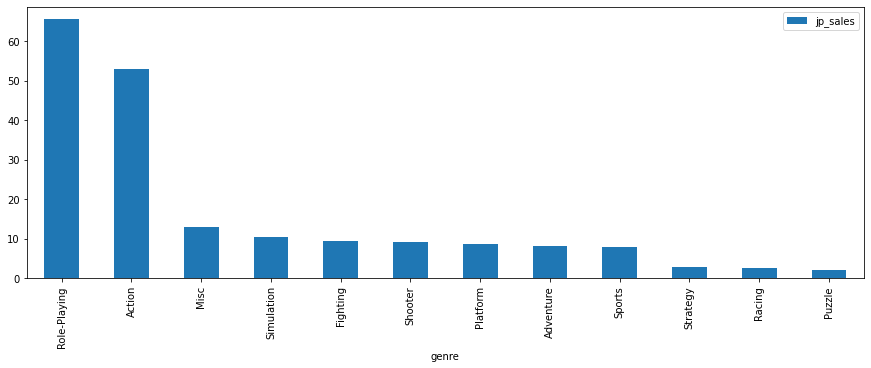

In [55]:
actual_data.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'jp_sales').plot(kind = 'bar', figsize=(15,5))

В японии преобладают игры жанров: ролевые игры, экшн, музыкальные, симуляторы и файтинги.

In [56]:
ESRB = actual_data.pivot_table(index = 'rating', values = ['eu_sales','jp_sales','na_sales'], aggfunc = 'sum')
ESRB

,eu_sales,jp_sales,na_sales
rating,,,
E,113.02,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02


<AxesSubplot:xlabel='rating'>

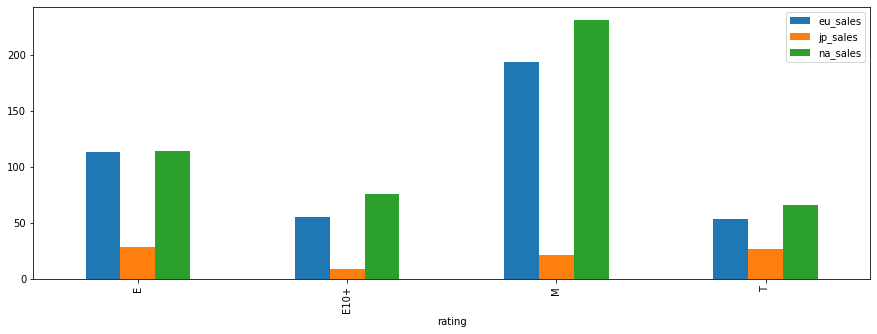

In [57]:
ESRB.plot(kind = 'bar', figsize=(15,5))

В европе и америке игры с рейтингом E и M сильно преобладают, в японии же все рейтинги кроме e10+ продаются одинаково хорошо.

#### Выод
В Северной америке преобладает платформа Xbox360, в европе Ps4 а в японии 3ds. В каждом регионе преобладают платформы произдводства их страны, кроме европе там преобладает японская платформа ps4. На продажи влиет возрастной рейтинг в европе и америке преобладют по прадажам E,M, для японии все рейтинги равномерно распределяются по продажам.

### Проверка гипотез

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

In [58]:
XOne = actual_data[(actual_data['platform'] == 'XOne') &  (actual_data['user_score'] > 0)]['user_score']
PC = actual_data[(actual_data['platform'] == 'PC') &  (actual_data['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг платформы Xbox One:', XOne.mean())
print('Средний пользовательский рейтинг платформы PC', PC.mean())

Средний пользовательский рейтинг платформы Xbox One: 6.521428571428572
Средний пользовательский рейтинг платформы PC 6.4286407766990274


H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H1: Средние пользовательские рейтинги платформ Xbox One и PC разные

alpha = .05

In [59]:
alpha = .05

results = st.ttest_ind(XOne, PC, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Нулевая Гипотеза подтвердилась, средний пользовательский рейтинг на XboxOne и PC одинаковые.

#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [60]:
Action = actual_data[(actual_data['genre'] == 'Action') &  (actual_data['user_score'] > 0)]['user_score']
Sports = actual_data[(actual_data['genre'] == 'Sports') &  (actual_data['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг жанра Action:', Action.mean())
print('Средний пользовательский рейтинг жанра Sports', Sports.mean())

Средний пользовательский рейтинг жанра Action: 6.825047801147227
Средний пользовательский рейтинг жанра Sports 5.455670103092784


H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые

H1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные
    
alpha = .05

In [61]:
alpha = .05

results = st.ttest_ind(Action, Sports, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.989458066467418e-20
Отвергаем нулевую гипотезу


Нулевая гипотеза не подтвердилась и мы ее отвергаем, средняя оценка пользователей жанров экшн и спорт разные.

### Вывод

Мы загрузили данные о играх и их продажах по годам и регионам и платформам. При первом анализе данных было обнаружено что в данных есть много пропусков в данных. Пропуски могут быть связаны с тем что не у всех игр за 2016 год уже есть данные о оценках и рейтинге и продажах. Так же это может быть связано с технической ошибкой или проблемой при выгрузке данных. В столбце с годом релиза нужно заменить формат данных на int, оценка пользавателей так же сменить на float. Так же нужно для удобства привести все названия столбцов к нижнему регистру.

Проверили данные на дубликаты и их не было найдено, привели все названия столбцов к нижнему ригистру. Были найдены 2 пропуска в данных с названием, из-за малого кол-ва удалили строки с этими пропусками. Столбце оценком пользователей обработали значения TBD 
и заменили их на NaN и привели данный столбец float. Столбец с оценкой критиков привели к типу данных int из-за того что все оценки целые числа. Остальные пропуски оставили как есть из-за их большого количества. Добавили столбец с сумарным кол-вом продаж по всем регионам.

Пик количества выпускаемых игр пришелся на 2006-2012 год что связано с актуальными платформами PS3 и Xbox360, с 2012 года количество уменьшилось из-за выхода новых игровых платформ и увелечения срока производства игр. Мы выявили средний срок иговой платформы 10 лет и для построения дальнейщих прогнозов взяли данные начиная с 2012 года.
Самыми популярными платформами являются PS2, Xbox360, PS3. Потонцеально прибыльными в будещем будет PS4, X One и PC из-за их актуальности а PS3 и Xbox360 потеряют свою популярность и прибыльность.
При количестве продаж на набирающих и популярных платформах видна корреляцию с оценкой критиков на продажи, самыми популярными жанрами являются экшены и шутеры.

В Северной америке преобладает платформа Xbox360, в европе Ps4 а в японии 3ds. В каждом регионе преобладают платформы произдводства их страны, кроме европе там преобладает японская платформа ps4. На продажи влиет возрастной рейтинг в европе и америке преобладют по прадажам E,M, для японии все рейтинги равномерно распределяются по продажам.

Гипотеза о том что средний пользовательский рейтинг на XboxOne и PC одинаковые подтвердилась.
Гипотеза средняя оценка пользователей жанров экшн и спорт разные не подтвердилась и мы ее отвергаем.



